In [1]:
from ultralytics import YOLO

In [2]:
model = YOLO("yolov8n.pt")

results = model.train(
    data="football-players-detection.v1i.yolov11/data.yaml",
    epochs=50,
    imgsz=960,
    batch=16,
    device="cuda",
    name="yolov8n_football"
)

New https://pypi.org/project/ultralytics/8.3.240 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.238 🚀 Python-3.13.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA RTX A6000, 48539MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=football-players-detection.v1i.yolov11/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_foot

In [2]:
model_players = YOLO("runs/detect/yolov8n_football/weights/best.pt")

In [3]:
results = model_players.predict(
    source="football-players-detection.v1i.yolov11/test/images",
    conf=0.3,
    device="cuda"
)


image 1/13 /home/alumno/Desktop/datos/Computer Vision/Football-Game-Detection/football-players-detection.v1i.yolov11/test/images/40cd38_7_6_png.rf.68ef7fcd663cdf0f5b96bacdbcd94e07.jpg: 544x960 1 ball, 23 players, 1 referee, 68.4ms
image 2/13 /home/alumno/Desktop/datos/Computer Vision/Football-Game-Detection/football-players-detection.v1i.yolov11/test/images/42ba34_1_5_png.rf.4337fde8fbe3640cf4351fb41ac9c3ca.jpg: 544x960 2 balls, 1 goalkeeper, 21 players, 3 referees, 4.7ms
image 3/13 /home/alumno/Desktop/datos/Computer Vision/Football-Game-Detection/football-players-detection.v1i.yolov11/test/images/42ba34_5_5_png.rf.ceb556bd4c92d41496ae1d8c56600c4a.jpg: 544x960 1 goalkeeper, 19 players, 1 referee, 4.7ms
image 4/13 /home/alumno/Desktop/datos/Computer Vision/Football-Game-Detection/football-players-detection.v1i.yolov11/test/images/4b770a_1_4_png.rf.5a45b3b841a06de414ceb802e34c136f.jpg: 544x960 1 goalkeeper, 20 players, 3 referees, 4.8ms
image 5/13 /home/alumno/Desktop/datos/Computer Vi


image 1/1 /home/alumno/Desktop/datos/Computer Vision/Football-Game-Detection/football-field-detection-1/test/images/2e57b9_9_7_png.rf.e14ccbae1e78fa459406e91ef033745f.jpg: 544x960 1 goalkeeper, 21 players, 3 referees, 5.9ms
Speed: 3.0ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 960)


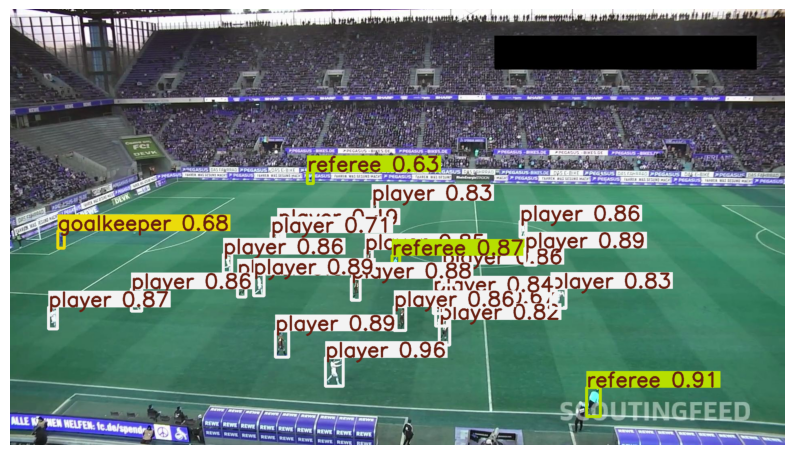

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

results = model_players("football-field-detection-1/test/images/2e57b9_9_7_png.rf.e14ccbae1e78fa459406e91ef033745f.jpg", conf=0.3, device="cuda")

annotated_image = results[0].plot()

plt.figure(figsize=(10, 7))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()



torch.Size([21, 4])


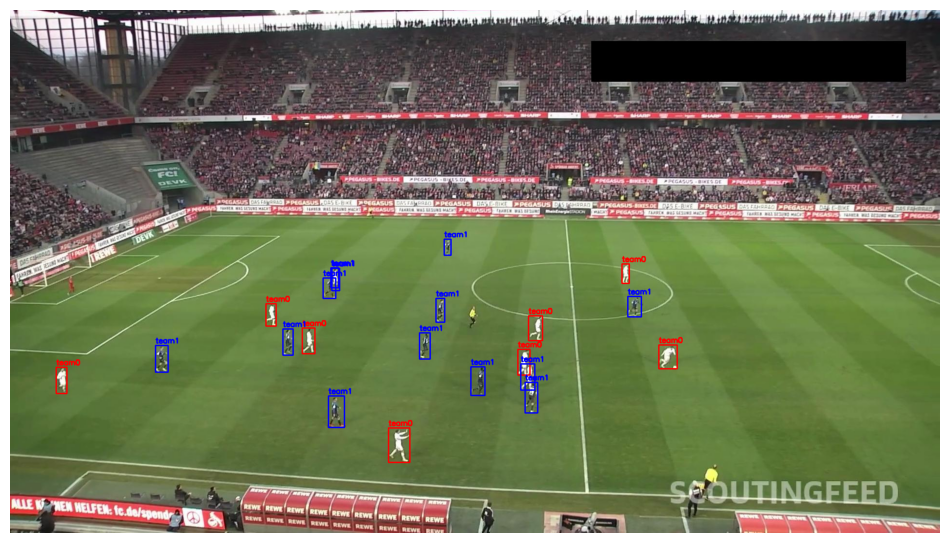

In [5]:
import torch
from torchvision import models, transforms
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"

# resnet to create embeddings for players
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  
resnet.to(device)
resnet.eval()

transform_resnet = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


img_path = "football-field-detection-1/test/images/2e57b9_9_7_png.rf.e14ccbae1e78fa459406e91ef033745f.jpg"
image_pil = Image.open(img_path).convert("RGB")
image_np = np.array(image_pil)

r = results[0]
player_id = [k for k,v in r.names.items() if v == "player"][0]
mask = r.boxes.cls == player_id
player_boxes = r.boxes.xyxy[mask]
print(player_boxes.shape)

# Crop the player boxes
cropped_players = []
for bbox in player_boxes:
    xmin, ymin, xmax, ymax = map(int, bbox)
    crop = image_pil.crop((xmin, ymin, xmax, ymax))
    cropped_players.append(crop)

# Obtain the embeddings
embeddings = []
for crop in cropped_players:
    input_tensor = transform_resnet(crop).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = resnet(input_tensor).squeeze().cpu().numpy()
    embeddings.append(emb)

embeddings = np.array(embeddings) 

# Kmeans clustering 
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(embeddings)

# Visualization
colors = [(255,0,0), (0,0,255)]
team_names = ["team0","team1"] 
image_draw = image_np.copy()

for bbox, label in zip(player_boxes, labels):
    xmin, ymin, xmax, ymax = map(int, bbox)
    color = colors[label]
    cv2.rectangle(image_draw, (xmin, ymin), (xmax, ymax), color, 2)
    cv2.putText(image_draw, team_names[label], (xmin, ymin-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


plt.figure(figsize=(12,7))
plt.imshow(image_draw)
plt.axis("off")
plt.show()


In [ ]:
model = YOLO("yolov8x-pose.pt")

results = model.train(
    data="football-field-detection-1/data.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    device="cuda",
    name="yolov8n_field",
    workers = 4
)

New https://pypi.org/project/ultralytics/8.3.240 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.238 🚀 Python-3.13.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA RTX A6000, 48539MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=football-field-detection-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_field, nbs

In [6]:
model_keypoints = YOLO("runs/pose/yolov8n_field/weights/best.pt")

In [7]:
results = model_keypoints.predict(
    source="football-field-detection-1/test/images",
    conf=0.3,
    device="cuda"
)


image 1/28 /home/alumno/Desktop/datos/Computer Vision/Football-Game-Detection/football-field-detection-1/test/images/08fd33_2_9_png.rf.7be05358d6ea8f3a22e415568e5035ae.jpg: 384x640 1 pitch, 78.5ms
image 2/28 /home/alumno/Desktop/datos/Computer Vision/Football-Game-Detection/football-field-detection-1/test/images/08fd33_4_11_png.rf.3a0ceefcabe0da6be48b8dfba535f29e.jpg: 384x640 1 pitch, 157.8ms
image 3/28 /home/alumno/Desktop/datos/Computer Vision/Football-Game-Detection/football-field-detection-1/test/images/08fd33_4_3_png.rf.0691d22335663daaafb5ea94c10dc519.jpg: 384x640 1 pitch, 8.7ms
image 4/28 /home/alumno/Desktop/datos/Computer Vision/Football-Game-Detection/football-field-detection-1/test/images/08fd33_9_2_png.rf.df80baf725860b185a548fe484af0ef3.jpg: 384x640 1 pitch, 8.7ms
image 5/28 /home/alumno/Desktop/datos/Computer Vision/Football-Game-Detection/football-field-detection-1/test/images/0a2d9b_2_2_png.rf.83c93b4eef206895fecec3a45c2965c8.jpg: 384x640 1 pitch, 8.6ms
image 6/28 /hom


image 1/1 /home/alumno/Desktop/datos/Computer Vision/Football-Game-Detection/football-field-detection-1/test/images/2e57b9_9_7_png.rf.e14ccbae1e78fa459406e91ef033745f.jpg: 384x640 1 pitch, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


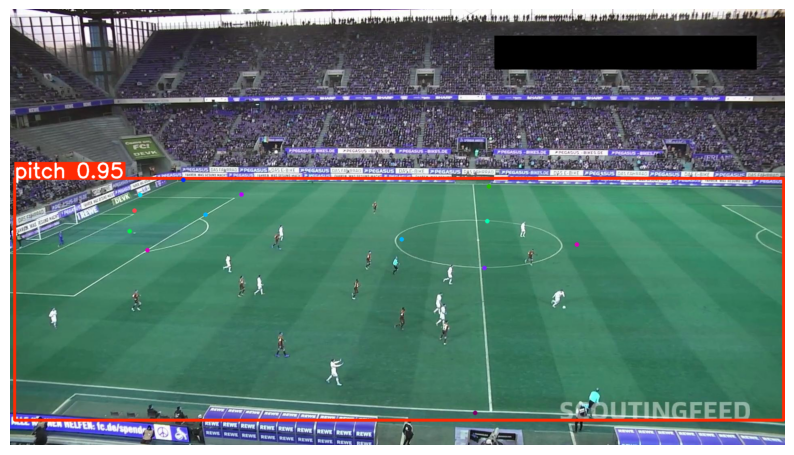

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

results = model_keypoints("football-field-detection-1/test/images/2e57b9_9_7_png.rf.e14ccbae1e78fa459406e91ef033745f.jpg", conf=0.3, device="cuda")

annotated_image = results[0].plot()

plt.figure(figsize=(10, 7))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()

In [ ]:
# !pip install git+https://github.com/roboflow/sports.git

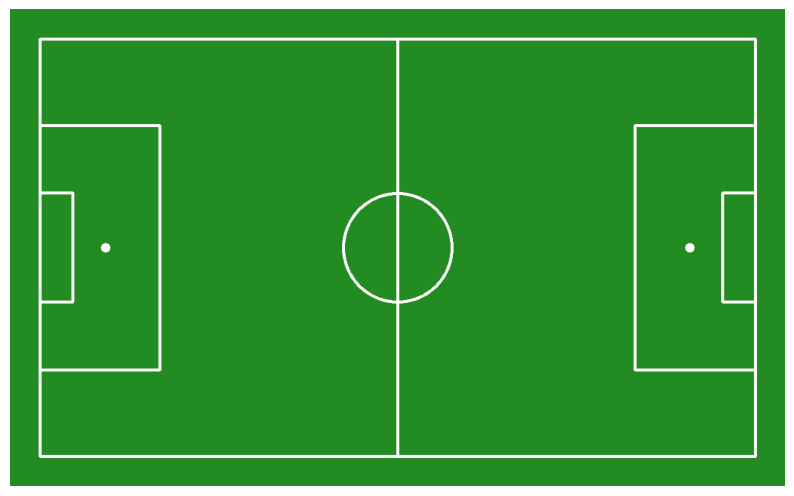

In [9]:
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

plt.figure(figsize=(10, 7))
plt.imshow(annotated_frame)
plt.axis("off")
plt.show()

In [ ]:
frame = np.array(image_pil)  
result_field = model_keypoints(frame, conf=0.3)[0]

key_points = result_field.keypoints

confidences = key_points.conf  


frame_points = key_points.xy
if isinstance(frame_points, torch.Tensor):
    frame_points = frame_points.cpu().numpy()

if isinstance(confidences, torch.Tensor):
    confidences = confidences.cpu().numpy()

confidence_threshold = 0.5
mask = confidences > confidence_threshold

frame_points_filtered = frame_points[mask]

pitch_vertices = np.array(CONFIG.vertices)
pitch_points_filtered = pitch_vertices[:len(frame_points_filtered)]



0: 384x640 1 pitch, 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


In [11]:
from sports.common.view import ViewTransformer

transformer = ViewTransformer(
    source=frame_points_filtered,
    target=pitch_points_filtered
)


In [ ]:
players_xy = []
for bbox in player_boxes:
    xmin, ymin, xmax, ymax = map(int, bbox)
    x_center = (xmin + xmax) / 2
    y_bottom = ymax
    players_xy.append([x_center, y_bottom])

players_xy = np.array(players_xy)


In [13]:
pitch_players_xy = transformer.transform_points(points=players_xy)

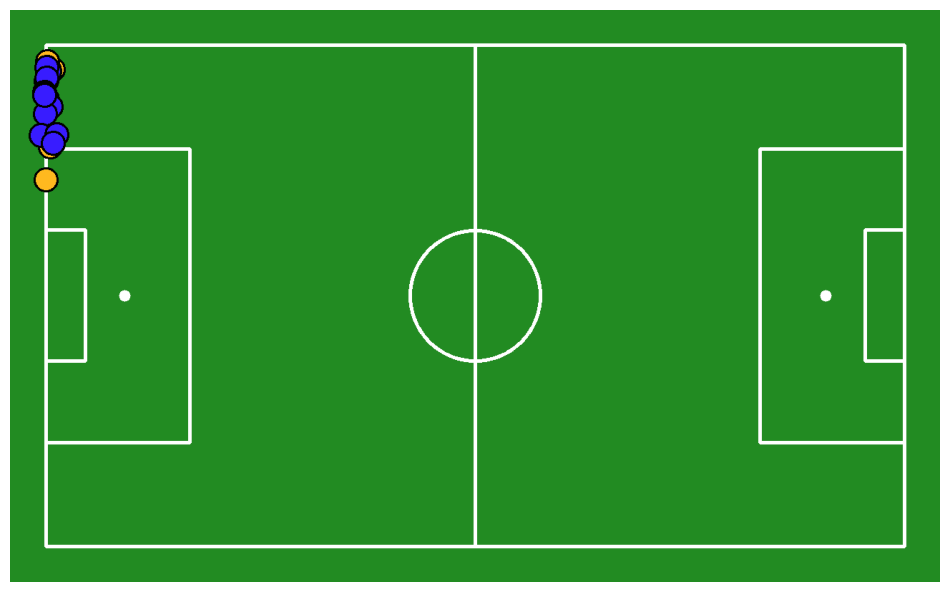

In [ ]:
from sports.annotators.soccer import draw_points_on_pitch
import supervision as sv

team0_color = sv.Color.from_hex("#1FB9FF")
team1_color = sv.Color.from_hex("#FF1C38")
edge_color = sv.Color.from_hex("#000000")


annotated_frame = draw_pitch(CONFIG)

team0_mask = labels == 0
team1_mask = labels == 1

annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[team0_mask],
    face_color=team0_color,
    edge_color=edge_color,
    radius=16,
    pitch=annotated_frame
)

annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[team1_mask],
    face_color=team1_color,
    edge_color=edge_color,
    radius=16,
    pitch=annotated_frame
)

plt.figure(figsize=(12,8))
plt.imshow(annotated_frame)
plt.axis("off")
plt.show()
